In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle
import wrds

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [5]:
unneeded_columns = ["ticker","year","quarter","gsector","gicdesc","y"]

In [6]:
market.connect()
sec.connect()
factors_df = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("financials",{"ticker":ticker})).drop(["gsector","gicdesc"],axis=1)
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["quarter"] = filings["quarter"].shift(1)
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","ticker"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-4)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

  4%|████████▎                                                                                                                                                                                               | 21/503 [00:02<00:43, 11.03it/s]

GOOGL 'date'


 11%|█████████████████████                                                                                                                                                                                   | 53/503 [00:06<00:52,  8.57it/s]

AVB 'date'


 13%|█████████████████████████                                                                                                                                                                               | 63/503 [00:07<00:44,  9.98it/s]

BRK.B 'date'


 16%|███████████████████████████████                                                                                                                                                                         | 78/503 [00:09<00:38, 11.03it/s]

BF.B 'date'


 16%|███████████████████████████████▊                                                                                                                                                                        | 80/503 [00:09<00:39, 10.60it/s]

BXP 'date'


 18%|███████████████████████████████████▍                                                                                                                                                                    | 89/503 [00:10<00:39, 10.42it/s]

CCL 'date'


 26%|███████████████████████████████████████████████████▍                                                                                                                                                   | 130/503 [00:15<00:35, 10.54it/s]

CPAY 'date'


 28%|████████████████████████████████████████████████████████▏                                                                                                                                              | 142/503 [00:16<00:38,  9.34it/s]

DAY 'date'


 29%|█████████████████████████████████████████████████████████▎                                                                                                                                             | 145/503 [00:16<00:32, 11.10it/s]

DELL 'date'


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                           | 151/503 [00:17<00:31, 11.31it/s]

DLR 'date'


 36%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                | 179/503 [00:20<00:29, 10.99it/s]

EQR 'date'
ERIE 'date'
ESS 'date'


 36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 183/503 [00:20<00:29, 10.95it/s]

EG 'date'


 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 194/503 [00:22<00:35,  8.71it/s]

FRT 'date'


 42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 213/503 [00:24<00:24, 12.03it/s]

GEV 'date'


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 262/503 [00:29<00:23, 10.28it/s]

IVZ 'date'
INVH 'date'


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 269/503 [00:30<00:27,  8.51it/s]

JCI 'date'


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 279/503 [00:31<00:22, 10.14it/s]

KIM 'date'


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 299/503 [00:34<00:22,  9.18it/s]

LYB 'date'


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 323/503 [00:36<00:20,  8.62it/s]

MAA 'date'


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 348/503 [00:39<00:16,  9.35it/s]

NCLH 'date'


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 353/503 [00:40<00:15,  9.47it/s]

NXPI 'date'


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 365/503 [00:41<00:11, 12.01it/s]

PLTR 'date'


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 399/503 [00:46<00:12,  8.37it/s]

REG 'date'


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 409/503 [00:47<00:11,  7.87it/s]

RCL 'date'


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 413/503 [00:47<00:09,  9.25it/s]

SLB 'date'


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 460/503 [00:53<00:04, 10.47it/s]

UDR 'date'


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 471/503 [00:54<00:03, 10.09it/s]

VLTO 'date'


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 477/503 [00:54<00:02, 12.36it/s]

VICI 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:58<00:00,  8.66it/s]

ZTS 'date'


In [7]:
factors_df = pd.concat(factors_df)

In [8]:
for column in factors_df:
    if column in factors_df[column]:
        factors_df.drop(column,axis=1,inplace=True)

In [9]:
factors_df = factors_df.fillna(0)

In [40]:
start_year = 2015
end_year = 2022
sim_end_year = 2025

In [41]:
model = XGBRegressor()
factors = ["ptb","roa","mktcap","bm","short_debt","divyield","adjclose"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[(factors_df["year"]>start_year) & (factors_df["year"]<end_year)].dropna()
sim = factors_df[(factors_df["year"]>=end_year) & (factors_df["year"]<sim_end_year)].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [42]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["expected_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["expected_return"] - price["rf"])
        price["sigma"] = price["adjclose"].rolling(262).std()
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 13%|█████████████████████████                                                                                                                                                                               | 63/503 [00:05<00:37, 11.78it/s]

BRK.B 'date'


 16%|███████████████████████████████                                                                                                                                                                         | 78/503 [00:07<00:33, 12.54it/s]

BF.B 'date'


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                             | 146/503 [00:13<00:29, 12.28it/s]

DELL 'date'


 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                | 178/503 [00:16<00:27, 12.00it/s]

ERIE 'date'


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 365/503 [00:33<00:10, 12.94it/s]

PLTR 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:49<00:00, 10.11it/s]

ZTS 'date'


In [43]:
sim = pd.concat(prices).fillna(0)
sim["quarter"] = [x.quarter for x in sim["date"]]
sim = sim[(sim["date"]<datetime(sim_end_year,1,1)) & (sim["date"]>datetime(end_year,1,1))]

In [57]:
# Initialize variables
structure = {"stock":0.5,"bond":0.4,"option":0.1}
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0,"pv":0} for _ in range(number_of_stocks)],
            "bonds": [{"ticker": "", "adjclose": 0, "quantity": 0,"pv":0} for _ in range(number_of_stocks)],
            "options": [{"ticker": "", "adjclose": 0, "quantity": 0,"pv":0} for _ in range(number_of_stocks)]
        }
        for _ in sim["ticker"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in tqdm(sim.sort_values("date")["date"].unique()):
    today = sim[sim["date"] == date].copy()
    expected_returns = today['expected_return'].values

    # Number of assets
    num_assets = len(expected_returns)
    
    # Linear programming to maximize expected return
    # The negative sign is used because linprog performs minimization, and we want to maximize returns
    c = -expected_returns
    
    # Constraints: weights sum to 1 (Ax = b)
    A_eq = np.ones((1, num_assets))
    b_eq = [1]
    
    # Bounds: No short-selling (weights between 0 and 1)
    bounds = [(0.0005, 0.1) for asset in range(num_assets)]
    
    # Perform linear programming
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    # Optimized weights
    optimized_weights = result.x
    today["weight"] = optimized_weights
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(len(positions)):
                position = positions[i]
                stocks = copy.deepcopy(position["stocks"])
                options = copy.deepcopy(position["options"])
                bonds = copy.deepcopy(position["bonds"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    bond = bonds[j]
                    option = options[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                        bond = Bond.update(row, bond)
                        position["bonds"][j] = bond
                        option = Option.update(row, option)
                        position["options"][j] = option
                positions[i] = position
            portfolio["positions"] = positions
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            notional = sum([position["stocks"][0]["pv"] for position in positions]) \
                            + sum([position["options"][0]["pv"] for position in positions]) \
                            + sum([position["bonds"][0]["pv"] for position in positions])
            for i in range(len(positions)):
                position = positions[i]
                stocks = copy.deepcopy(position["stocks"])
                options = copy.deepcopy(position["options"])
                bonds = copy.deepcopy(position["bonds"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    bond = bonds[j]
                    option = options[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today.iloc[i]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 90):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional * structure["stock"] * opportunity_row["weight"])
                            position["stocks"][j] = stock
                            option = Option.sell(row, option)
                            position["options"][j] = option
                            trades.append(option)
                            option = Option.buy(opportunity_row, option, notional * structure["option"] * opportunity_row["weight"])
                            position["options"][j] = option
                            bond = Bond.sell(row, bond)
                            position["bonds"][j] = bond
                            trades.append(bond)
                            bond = Bond.buy(opportunity_row, bond, notional * structure["bond"] * opportunity_row["weight"])
                            position["bonds"][j] = bond
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                notional = float(cash)
                for i in range(len(positions)):
                    position = positions[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today.iloc[i]
                        stock = Stock.buy(row, stock, notional * structure["stock"] * row["weight"])
                        position["stocks"][j] = stock
                        option = Option.buy(row, option, notional * structure["option"] * row["weight"])
                        position["options"][j] = option
                        bond = Bond.buy(row, bond, notional * structure["bond"] * row["weight"])
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

  0%|▎                                                                                                                                                                                                        | 1/683 [00:00<01:57,  5.81it/s]

Error on date 2022-01-03 00:00:00: single positional indexer is out-of-bounds


 10%|███████████████████▎                                                                                                                                                                                    | 66/683 [00:24<03:53,  2.64it/s]

Error on date 2022-04-06 00:00:00: single positional indexer is out-of-bounds
Error on date 2022-04-07 00:00:00: single positional indexer is out-of-bounds


 41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 280/683 [01:58<03:11,  2.11it/s]

Error on date 2023-02-13 00:00:00: single positional indexer is out-of-bounds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [04:53<00:00,  2.33it/s]


In [58]:
portfolios = []
for state in states:
    for i in range(len(positions)):
        for j in range(number_of_stocks):
            for asset_class in ["stocks","bonds","options"]:
                view = state["positions"][i][asset_class][j]
                view["date"] = state["date"]
                view["asset_class"] = asset_class
            portfolios.append(state["positions"][i]["stocks"][j])
            portfolios.append(state["positions"][i]["options"][j])
            portfolios.append(state["positions"][i]["bonds"][j])

In [59]:
performance = pd.DataFrame(portfolios).pivot_table(index=["date","ticker"],columns="asset_class",values="pv").reset_index().sort_values("date")
performance = performance.groupby("date").agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()

In [60]:
# plt.figure(figsize=(10, 6))  
# for sector in performance["sector"].unique():
#     sector_perf = performance[performance["sector"]==sector]
#     plt.plot(sector_perf["date"].values,sector_perf["stocks"].values)
#     # plt.legend(performance["sector"].unique())
# plt.show()

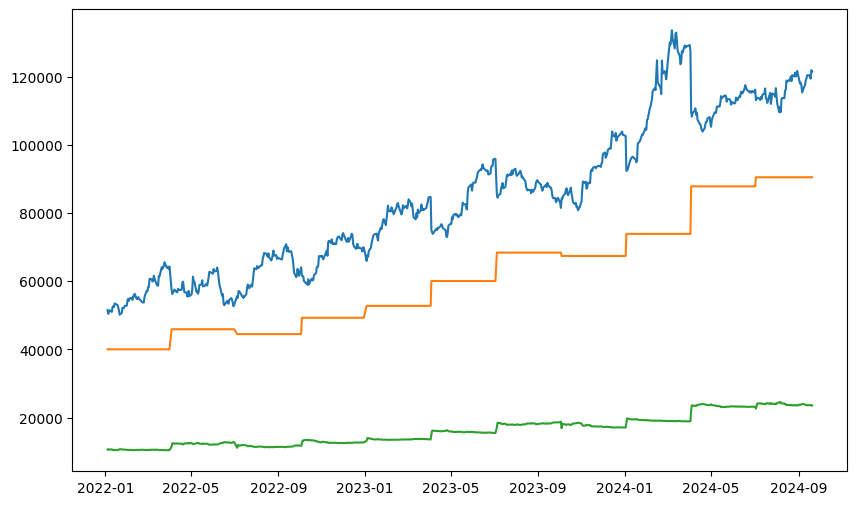

In [61]:
plt.figure(figsize=(10, 6)) 
plt.plot(performance["date"].values,performance["stocks"].values)
plt.plot(performance["date"].values,performance["bonds"].values)
plt.plot(performance["date"].values,performance["options"].values)
plt.show()

In [62]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [63]:
visualization["pv"] = visualization["stocks"] + visualization["bonds"] + visualization["options"]
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

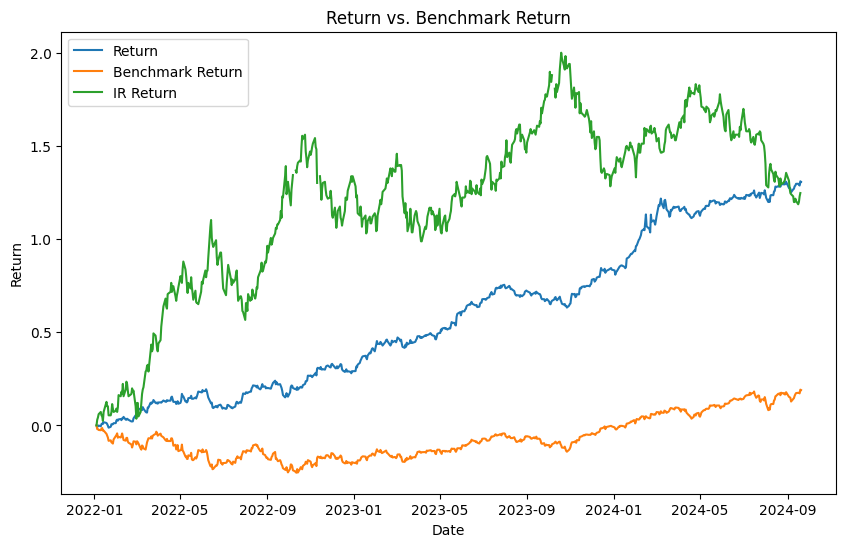

In [64]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [65]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

2.728854504275737

In [66]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["cash_flow"] = (t["adjclose"] - t["buy_price"]) * t["quantity"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [67]:
t.sort_values("cash_flow",ascending=False).head(30)

,ticker,adjclose,quantity,pv,buy_price,buy_date,sell_date,strike_price,premium,contract_price,notional,return,rate,GICS Sector,cash_flow,hpr
13026,SMCI,1015.570000,33.030334,33544.616066,280.640000,2024-01-03,2024-04-03,NaN,NaN,NaN,NaN,2.618764,NaN,Information Technology,24274.983197,91
8613,SMCI,255.000000,68.687458,17515.301701,109.460000,2023-04-04,2023-07-05,NaN,NaN,NaN,NaN,1.329618,NaN,Information Technology,9996.772587,92
3516,FSLR,143.060000,83.997818,12016.727788,66.230000,2022-07-05,2022-10-04,NaN,NaN,NaN,NaN,1.160048,NaN,Information Technology,6453.552327,91
6906,NVDA,27.438574,461.351746,12658.834005,14.305021,2023-01-03,2023-04-04,NaN,NaN,NaN,NaN,0.918108,NaN,Information Technology,6059.187741,91
1035,OXY,56.110405,166.172297,9323.994793,30.089251,2022-01-03,2022-04-04,NaN,NaN,NaN,NaN,0.864799,NaN,Energy,4323.994793,91
8379,NVDA,42.299278,274.013115,11590.556821,27.438574,2023-04-04,2023-07-05,NaN,NaN,NaN,NaN,0.541599,NaN,Information Technology,4072.027707,92
7302,WBD,15.150000,691.786820,10480.570324,9.540000,2023-01-03,2023-04-04,NaN,NaN,NaN,NaN,0.588050,NaN,Communication Services,3880.924061,91
11094,KEY,13.608269,874.696926,11903.110732,9.668189,2023-10-04,2024-01-03,NaN,NaN,NaN,NaN,0.407530,NaN,Financials,3446.375628,91
966,MOS,63.340638,131.871891,8352.849773,37.915586,2022-01-03,2022-04-04,NaN,NaN,NaN,NaN,0.670570,NaN,Materials,3352.849773,91
14196,MPWR,839.220000,17.015797,14279.997424,648.852917,2024-04-03,2024-07-03,NaN,NaN,NaN,NaN,0.293390,NaN,Information Technology,3239.247696,91


In [68]:
t.groupby(["GICS Sector"]).agg({"cash_flow":"mean","hpr":"mean"}).reset_index().sort_values("cash_flow").tail(50)

,GICS Sector,cash_flow,hpr
9,Real Estate,-1.773229,91.200000
10,Utilities,2.646047,91.201299
1,Consumer Discretionary,4.529973,91.201980
2,Consumer Staples,8.448943,91.197802
4,Financials,11.224634,91.200000
8,Materials,13.000127,91.200000
0,Communication Services,14.188946,91.200000
5,Health Care,14.817000,91.199319
6,Industrials,20.690498,91.199734
3,Energy,63.767225,91.200000


In [69]:
performance

asset_class,date,stocks,bonds,options
0,2022-01-04,51485.895191,40000.000000,10598.826988
1,2022-01-05,50411.638554,40000.000000,10706.224880
2,2022-01-06,51239.118506,40000.000000,10620.422378
3,2022-01-07,51442.237195,40000.000000,10592.476653
4,2022-01-10,50989.376704,40000.000000,10640.413198
...,...,...,...,...
674,2024-09-16,120404.164457,90461.710821,23599.587498
675,2024-09-17,119796.763170,90461.710821,23640.403698
676,2024-09-18,119373.345042,90461.710821,23675.182808
677,2024-09-19,121872.067310,90461.710821,23484.697804
